In [1]:
import networkx as nx
import pandas as pd
import numpy as np
from itertools import combinations
import pickle


In [4]:
df = pd.read_csv('./data/EJOR_vol_256-295.csv')
print(df.shape)
df.tail()

(4786, 4)


,title,author,affiliation,author idx
4781,"Technical, allocative and overall efficiency: ...",Paul W. Wilson,Department of Economics and School of Computin...,2
4782,Quantile Stochastic Frontiers,Mike G. Tsionas,"Lancaster University Management School, LA1 4Y...",1
4783,General lattice methods for arithmetic Asian o...,Anna Maria Gambaro,Dipartimento di Studi per l’Economia e l’Impre...,1
4784,General lattice methods for arithmetic Asian o...,Ioannis Kyriakou,"Cass Business School, City, University of Lond...",2
4785,General lattice methods for arithmetic Asian o...,Gianluca Fusai,Dipartimento di Studi per l’Economia e l’Impre...,3


In [5]:
def aff2univ(str):
    univ = [x for x in str.split(', ') if x.lower().find('univ') !=-1]
    if len(univ) > 0:
        univ = univ[0]
    else:
        univ = str
    return univ
df['affiliation'] = df['affiliation'].apply(lambda s: aff2univ(s))
# df

In [6]:
len(df['affiliation'].unique())

1739

In [7]:
nodes = df['affiliation'].unique().tolist()
print(len(nodes))

1739


In [8]:
edges = []
last_title = ''
author_list = list()
for i in range(df.shape[0]):
    this_title = df['title'][i]
    if this_title != last_title and i != 0:
        ## calculate
        author_list = list(set(author_list))
        if len(author_list) > 1:
            # print(list(combinations(author_list, 2)))
            edges += list(combinations(author_list, 2))
        author_list = [df['affiliation'][i]]
    else:
        author_list.append(df['affiliation'][i])

    last_title = this_title
author_list = list(set(author_list))
if len(author_list) > 1:
    # print(list(combinations(author_list, 2)))
    edges += list(combinations(author_list, 2))

print(len(edges))

2204


In [9]:
### test case
# t = ['my article'] *3 + ['his'] *4
# a = ['V','V', 'U', 'V', 'L', 'L', 'U']
# df = pd.DataFrame({'title': t,'affiliation': a})

In [10]:
G = nx.MultiGraph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

SingleG = nx.Graph(G)

In [11]:
DC = nx.degree_centrality(G)
DC

{'Tilburg University': 0.010356731875719217,
 'DM-Universidade Estadual do Piauí': 0.0005753739930955121,
 'Universidade Federal do Piauí': 0.0005753739930955121,
 'Fudan University': 0.005178365937859608,
 'Stony Brook University': 0.0017261219792865361,
 'IBM Research – Ireland, B3 F14 IBM Campus Damastown, Dublin 15, Ireland': 0.0011507479861910242,
 'University of Edinburgh School of Mathematics': 0.0011507479861910242,
 'Lehigh University': 0.0011507479861910242,
 'University of Belgrade': 0.0005753739930955121,
 'Linköping University': 0.0023014959723820483,
 'Département de Mathématiques et Génie Industriel, École Polytechnique de Montréal, C.P. 6079, succ. Centre-ville, Montréal, Québec H3C 3A7, Canada': 0.0005753739930955121,
 'Université du Québec à Chicoutimi': 0.0005753739930955121,
 'Johannes Gutenberg University Mainz': 0.0011507479861910242,
 'University of Central Oklahoma': 0.0005753739930955121,
 'University of Central Florida': 0.0017261219792865361,
 'University of 

In [12]:
not_zero = []
for k in DC.keys():
    if DC[k] != 0:
        not_zero.append(k)

In [13]:
np.save('institute_list_not_zero_uni.npy', not_zero)

In [23]:
structural_hole_local_multiple = dict()
for node in nodes:
    structural_hole_local_multiple[node] = nx.local_constraint(G, node, node)


In [24]:
structural_hole_effective_single = nx.effective_size(SingleG)

In [38]:
DC_notzero = {}
for k in not_zero:
    DC_notzero[k] = DC[k]


In [39]:
SH_local_notzero = {}
for k in not_zero:
    SH_local_notzero[k] = structural_hole_local_multiple[k]


In [40]:
SH_eff_notzero = {}
for k in not_zero:
    SH_eff_notzero[k] = structural_hole_effective_single[k]


In [41]:
print(len(DC_notzero))
print(len(SH_local_notzero))
print(len(SH_eff_notzero))

1550
1550
1550


In [42]:
df_tmp = pd.DataFrame({"institute": list(DC_notzero.keys()), \
    'degree centrality': list(DC_notzero.values()),\
    'structural hole (effective)': list(SH_eff_notzero.values()), \
    'structural hole (local)': list(SH_local_notzero.values())
    }, index=range(len(DC_notzero)))
df_tmp.to_csv('input.csv')

Visualization

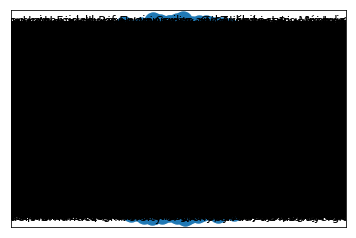

In [103]:
import matplotlib.pyplot as plt

subax1 = plt.plot()
nx.draw_networkx(G, with_labels=True)   # default spring_layout



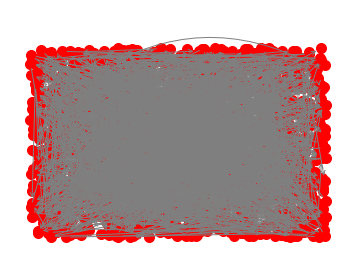

In [104]:
pos = nx.random_layout(G)
nx.draw_networkx_nodes(G, pos, node_color = 'r', node_size = 100, alpha = 1, label='test')
ax = plt.gca()
for e in G.edges:
    ax.annotate("",
                xy=pos[e[0]], xycoords='data',
                xytext=pos[e[1]], textcoords='data',
                arrowprops=dict(arrowstyle="->", color="0.5",
                                shrinkA=5, shrinkB=5,
                                patchA=None, patchB=None,
                                connectionstyle="arc3,rad=rrr".replace('rrr',str(0.3*e[2])
                                ),
                                ),
                )
plt.axis('off')
plt.show()

In [85]:
from pyvis import network as pvnet

def plot_g_pyviz(G, name='out.html', height='30px', width='50px'):
    g = G.copy() # some attributes added to nodes
    net = pvnet.Network(notebook=True, directed=True, height=height, width=width)
    opts = '''
        var options = {
          "physics": {
            "forceAtlas2Based": {
              "gravitationalConstant": -100,
              "centralGravity": 0.11,
              "springLength": 100,
              "springConstant": 0.09,
              "avoidOverlap": 1
            },
            "minVelocity": 0.75,
            "solver": "forceAtlas2Based",
            "timestep": 0.22
          }
        }
    '''

    net.set_options(opts)
    # uncomment this to play with layout
    # net.show_buttons(filter_=['physics'])
    net.from_nx(g)
    return net.show(name)


G = nx.MultiDiGraph()
[G.add_node(n) for n in range(5)]
G.add_edge(0, 1, label=1)
G.add_edge(0, 1, label=11)
G.add_edge(0, 2, label=2)
G.add_edge(0, 3, label=3)
G.add_edge(3, 4, label=34)

plot_g_pyviz(G)



In [124]:
# Load
with open('degree_centrality_multiGraph.pickle', 'rb') as f:
    new_dict = pickle.load(f)

multi = pd.DataFrame({'affiliation': list(new_dict.keys()), 'num': list(new_dict.values())},\
     index=range(len(new_dict))).sort_values('affiliation')

In [125]:
# Load
with open('degree_centrality_singleGraph.pickle', 'rb') as f:
    new_dict = pickle.load(f)

single = pd.DataFrame({'affiliation': list(new_dict.keys()), 'num': list(new_dict.values())},\
     index=range(len(new_dict))).sort_values('affiliation')

In [127]:
num_multi = list(multi['num'])
num_single = list(single['num'])

In [130]:
for i in range(multi.shape[0]):
    if num_single[i] < num_multi[i]:
        print(multi['affiliation'][i])

QUT Business School, Business and Management, Queensland University of Technology, 2 George St, Brisbane, QLD 4000, Australia
Département de Mathématiques et de Génie Industriel, Polytechnique Montréal and GERAD C.P. 6079, Succ. Centre-Ville, Montreal, Quebec H3C 3A7, Canada
Sorbonne Universités, UPMC Univ Paris 06, CNRS, LIP6 UMR 7606, 4 Place Jussieu, 75005 Paris, France
School of Science, Communication University of China, Beijing 100024, People’s Republic of China
Pontificia Universidad Católica de Valparaíso, Chile
Department of Transportation Engineering, Isfahan University of Technology, Isfahan, Iran
Department of Industrial Engineering, Clemson University, 100B Freeman Hall, Clemson SC, 29634-0020, United States
Institute for Transport and Logistics Management, WU (Vienna University of Economics and Business), Welthandelsplatz 1 1, Vienna 1020, Austria
Kedge Business School, The Centre of Excellence in Supply Chain (CESIT), Bordeaux, France
Department of Mathematics, Escuela P